In [1]:
%matplotlib inline

import os
import cv2
import torch
import torchvision
import numpy as np

from pdb import set_trace as bp
from parse_config import hparam as config
from models import ResNet18
from data import TorchDatasets, BaseDataLoader
from utils import *
from trainer import fit

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

/workspace/home/harv/Desktop/Session10/parse_config.py:37: YAMLLoadWarning: calling yaml.load_all() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  for doc in docs:


In [2]:
device

device(type='cuda')

In [3]:
trainset = TorchDatasets('CIFAR10', './data', True, True).dataset
testset = TorchDatasets('CIFAR10', './data', False, True).dataset

Files already downloaded and verified
Files already downloaded and verified


In [4]:
np.array(trainset.__getitem__(0)[0]).shape

(32, 32, 3)

In [46]:
train_transform_dict = {'HorizontalFlip': {'p': 0.5},
                        'PadIfNeeded': {'min_height': 40, 'min_width': 40}, 
                        'RandomCrop': {'height': 32, 'width': 32},
                        'Cutout': {'num_holes': 2, 'max_h_size': 8, 'max_w_size': 8, 'fill_value': 127.5},
                        'Normalize': {'mean': (0.5,0.5,0.5), 'std': (0.5,0.5,0.5)}}

test_transform_dict = {'Normalize': {'mean': (0.5,0.5,0.5), 'std': (0.5,0.5,0.5)}}

train_album_compose = getCompose_simple(train_transform_dict)
test_album_compose = getCompose_simple(test_transform_dict)

setattr(trainset, 'transform', train_album_compose)
setattr(testset, 'transform', test_album_compose)

In [40]:
model = ResNet18().to(device)

In [47]:
trainloader = BaseDataLoader(trainset,
                              batch_size=config.train.batch_size,
                              shuffle=config.train.shuffle,
                              num_workers=config.train.loader_workers)
testloader = BaseDataLoader(testset,
                              batch_size=config.val.batch_size,
                              shuffle=config.val.shuffle,
                              num_workers=config.val.loader_workers)              

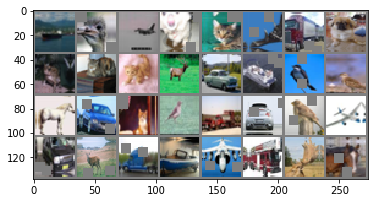

In [48]:
images, labels = iter(trainloader).next()
imshow(torchvision.utils.make_grid(images))

In [ ]:
# get_summary(model, (3,32,32))

In [49]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-7, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [ ]:
# lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
# lr_finder.range_test(trainloader, end_lr=10, num_iter=400)
# lr_finder.plot() 
# lr_finder.reset() 
# print('Best loss is: {}'.format(lr_finder.best_loss))
# lr_from_finder = (lr_finder.history['lr'][(lr_finder.history['loss'].index(lr_finder.best_loss)) - 1])
# print("New LR from finder is {}".format(lr_from_finder))



Learning rate search finished. See the graph with {finder_name}.plot()


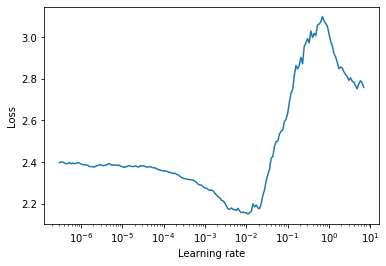

2.149004574967818 0.01


In [50]:
bestloss, lr_from_finder = finderplot_getlr(model, trainloader, optimizer, criterion, 10, 200, device)
print(bestloss, lr_from_finder)
optimizer = torch.optim.SGD(model.parameters(), lr=lr_from_finder, momentum=0.9)

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:2427: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


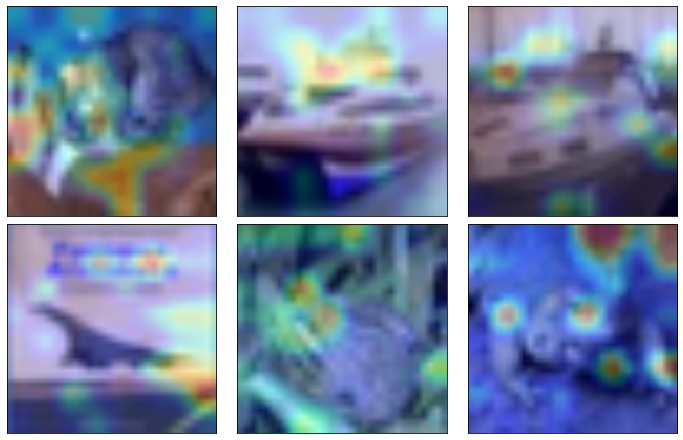

In [51]:
# GradCAM before training, on a few sample images
grad_cam = GradCam(model,
                   target_layer_names=["layer3.1.conv2"],
                   use_cuda=use_cuda)

images, labels = iter(testloader).next()
returned_outputs = grad_cam(images[:6],
         dataset_mean=[0.5, 0.5, 0.5],
         dataset_std=[0.5, 0.5, 0.5],
         index=None,
         display=True,
         columns=3,
         rows=2)


In [52]:
train_acc, train_losses, test_acc, test_losses, misclassified_list = fit(trainloader,
                                                                          testloader,
                                                                          model,
                                                                          config.train.epochs,
                                                                          optimizer,                                    
                                                                          criterion,
                                                                          device,
                                                                          scheduler=scheduler,
                                                                          snapshot_path=os.path.join(config.model.snapshot_path, "checkpoint_check"))

  0%|          | 0/1563 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.2762629985809326 Batch_id=1562 Accuracy=44.74: 100%|██████████| 1563/1563 [02:16<00:00, 11.47it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 1.1597, Accuracy: 5877/10000 (58.77%)

Now, the LR is 0.01

Val loss lowered, saving weights of this epoch!
EPOCH: 1


Loss=22.677194595336914 Batch_id=1562 Accuracy=33.70: 100%|██████████| 1563/1563 [02:16<00:00, 11.45it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 1.4058, Accuracy: 4869/10000 (48.69%)

Now, the LR is 0.01
EPOCH: 2


Loss=20.943267822265625 Batch_id=1562 Accuracy=55.00: 100%|██████████| 1563/1563 [02:15<00:00, 11.51it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 1.2103, Accuracy: 5881/10000 (58.81%)

Now, the LR is 0.01
EPOCH: 3


Loss=22.585060119628906 Batch_id=1562 Accuracy=65.11: 100%|██████████| 1563/1563 [02:16<00:00, 11.73it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.9709, Accuracy: 6660/10000 (66.60%)

Now, the LR is 0.01

Val loss lowered, saving weights of this epoch!
EPOCH: 4


Loss=14.175674438476562 Batch_id=1562 Accuracy=71.63: 100%|██████████| 1563/1563 [02:16<00:00, 11.48it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.6819, Accuracy: 7661/10000 (76.61%)

Now, the LR is 0.01

Val loss lowered, saving weights of this epoch!
EPOCH: 5


Loss=17.113920211791992 Batch_id=1562 Accuracy=75.46: 100%|██████████| 1563/1563 [02:16<00:00, 11.46it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.5878, Accuracy: 7998/10000 (79.98%)

Now, the LR is 0.01

Val loss lowered, saving weights of this epoch!
EPOCH: 6


Loss=6.6393890380859375 Batch_id=1562 Accuracy=78.02: 100%|██████████| 1563/1563 [02:16<00:00, 11.46it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.5301, Accuracy: 8220/10000 (82.20%)

Now, the LR is 0.01

Val loss lowered, saving weights of this epoch!
EPOCH: 7


Loss=6.2978291511535645 Batch_id=1562 Accuracy=80.06: 100%|██████████| 1563/1563 [02:16<00:00, 11.48it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.5108, Accuracy: 8297/10000 (82.97%)

Now, the LR is 0.01

Val loss lowered, saving weights of this epoch!
EPOCH: 8


Loss=3.140099287033081 Batch_id=1562 Accuracy=81.70: 100%|██████████| 1563/1563 [02:16<00:00, 11.35it/s] 
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.5230, Accuracy: 8275/10000 (82.75%)

Now, the LR is 0.01
EPOCH: 9


Loss=8.511514663696289 Batch_id=1562 Accuracy=83.13: 100%|██████████| 1563/1563 [02:16<00:00, 11.79it/s] 
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.4643, Accuracy: 8452/10000 (84.52%)

Now, the LR is 0.01

Val loss lowered, saving weights of this epoch!
EPOCH: 10


Loss=5.125854969024658 Batch_id=1562 Accuracy=84.23: 100%|██████████| 1563/1563 [02:16<00:00, 11.46it/s] 
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.4171, Accuracy: 8594/10000 (85.94%)

Now, the LR is 0.01

Val loss lowered, saving weights of this epoch!
EPOCH: 11


Loss=9.520984649658203 Batch_id=1562 Accuracy=85.26: 100%|██████████| 1563/1563 [02:16<00:00, 11.68it/s] 
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.4646, Accuracy: 8457/10000 (84.57%)

Now, the LR is 0.01
EPOCH: 12


Loss=6.9077467918396 Batch_id=1562 Accuracy=85.98: 100%|██████████| 1563/1563 [02:16<00:00, 11.44it/s]   
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.4062, Accuracy: 8686/10000 (86.86%)

Now, the LR is 0.01

Val loss lowered, saving weights of this epoch!
EPOCH: 13


Loss=10.849530220031738 Batch_id=1562 Accuracy=86.88: 100%|██████████| 1563/1563 [02:16<00:00, 11.45it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.4226, Accuracy: 8634/10000 (86.34%)

Now, the LR is 0.01
EPOCH: 14


Loss=0.2158818244934082 Batch_id=1562 Accuracy=87.50: 100%|██████████| 1563/1563 [02:15<00:00, 11.51it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.3752, Accuracy: 8764/10000 (87.64%)

Now, the LR is 0.01

Val loss lowered, saving weights of this epoch!
EPOCH: 15


Loss=6.473142147064209 Batch_id=1562 Accuracy=88.01: 100%|██████████| 1563/1563 [02:16<00:00, 11.54it/s] 
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.3787, Accuracy: 8748/10000 (87.48%)

Now, the LR is 0.01
EPOCH: 16


Loss=0.4287247657775879 Batch_id=1562 Accuracy=88.59: 100%|██████████| 1563/1563 [02:16<00:00, 11.46it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.3949, Accuracy: 8780/10000 (87.80%)

Now, the LR is 0.01
EPOCH: 17


Loss=3.9628548622131348 Batch_id=1562 Accuracy=89.13: 100%|██████████| 1563/1563 [02:16<00:00, 11.48it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.3423, Accuracy: 8874/10000 (88.74%)

Now, the LR is 0.01

Val loss lowered, saving weights of this epoch!
EPOCH: 18


Loss=7.268185615539551 Batch_id=1562 Accuracy=89.93: 100%|██████████| 1563/1563 [02:15<00:00, 11.32it/s] 
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.3458, Accuracy: 8882/10000 (88.82%)

Now, the LR is 0.01
EPOCH: 19


Loss=6.64695930480957 Batch_id=1562 Accuracy=90.09: 100%|██████████| 1563/1563 [02:16<00:00, 11.49it/s]  
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.3177, Accuracy: 8948/10000 (89.48%)

Now, the LR is 0.01

Val loss lowered, saving weights of this epoch!
EPOCH: 20


Loss=6.052821159362793 Batch_id=1562 Accuracy=90.56: 100%|██████████| 1563/1563 [02:15<00:00, 11.62it/s] 
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.3562, Accuracy: 8895/10000 (88.95%)

Now, the LR is 0.01
EPOCH: 21


Loss=5.093937397003174 Batch_id=1562 Accuracy=91.09: 100%|██████████| 1563/1563 [02:15<00:00, 11.43it/s]  
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.3371, Accuracy: 8937/10000 (89.37%)

Now, the LR is 0.01
EPOCH: 22


Loss=4.835347652435303 Batch_id=1562 Accuracy=91.31: 100%|██████████| 1563/1563 [02:15<00:00, 11.56it/s] 
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.3477, Accuracy: 8925/10000 (89.25%)

Now, the LR is 0.01
EPOCH: 23


Loss=10.608112335205078 Batch_id=1562 Accuracy=91.78: 100%|██████████| 1563/1563 [02:16<00:00, 11.49it/s] 
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.3052, Accuracy: 9034/10000 (90.34%)

Now, the LR is 0.01

Val loss lowered, saving weights of this epoch!
EPOCH: 24


Loss=6.6488356590271 Batch_id=1562 Accuracy=92.00: 100%|██████████| 1563/1563 [02:16<00:00, 11.62it/s]   
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.3298, Accuracy: 9006/10000 (90.06%)

Now, the LR is 0.01
EPOCH: 25


Loss=4.348940372467041 Batch_id=1562 Accuracy=92.27: 100%|██████████| 1563/1563 [02:15<00:00, 11.50it/s]  
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.3269, Accuracy: 9002/10000 (90.02%)

Now, the LR is 0.01
EPOCH: 26


Loss=3.5209875106811523 Batch_id=1562 Accuracy=92.85: 100%|██████████| 1563/1563 [02:16<00:00, 11.47it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.3011, Accuracy: 9085/10000 (90.85%)

Now, the LR is 0.01

Val loss lowered, saving weights of this epoch!
EPOCH: 27


Loss=4.612701416015625 Batch_id=1562 Accuracy=93.08: 100%|██████████| 1563/1563 [02:16<00:00, 11.49it/s] 
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.3094, Accuracy: 9036/10000 (90.36%)

Now, the LR is 0.01
EPOCH: 28


Loss=7.574258327484131 Batch_id=1562 Accuracy=93.01: 100%|██████████| 1563/1563 [02:16<00:00, 11.45it/s]  
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.2809, Accuracy: 9125/10000 (91.25%)

Now, the LR is 0.01

Val loss lowered, saving weights of this epoch!
EPOCH: 29


Loss=0.6287145614624023 Batch_id=1562 Accuracy=93.41: 100%|██████████| 1563/1563 [02:16<00:00, 11.36it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.2967, Accuracy: 9088/10000 (90.88%)

Now, the LR is 0.01
EPOCH: 30


Loss=0.3999171257019043 Batch_id=1562 Accuracy=93.66: 100%|██████████| 1563/1563 [02:16<00:00, 11.49it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.3121, Accuracy: 9065/10000 (90.65%)

Now, the LR is 0.01
EPOCH: 31


Loss=2.793801784515381 Batch_id=1562 Accuracy=93.87: 100%|██████████| 1563/1563 [02:16<00:00, 11.48it/s] 
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.2927, Accuracy: 9110/10000 (91.10%)

Now, the LR is 0.01
EPOCH: 32


Loss=7.486413478851318 Batch_id=1562 Accuracy=94.00: 100%|██████████| 1563/1563 [02:16<00:00, 11.48it/s]  
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.3204, Accuracy: 9068/10000 (90.68%)

Now, the LR is 0.01
EPOCH: 33


Loss=2.565786838531494 Batch_id=1562 Accuracy=94.29: 100%|██████████| 1563/1563 [02:16<00:00, 11.67it/s]  
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.2904, Accuracy: 9164/10000 (91.64%)

Now, the LR is 0.01
EPOCH: 34


Loss=3.953874111175537 Batch_id=1562 Accuracy=94.49: 100%|██████████| 1563/1563 [02:14<00:00, 11.58it/s]  
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.2934, Accuracy: 9138/10000 (91.38%)

Now, the LR is 0.01
EPOCH: 35


Loss=4.215712547302246 Batch_id=1562 Accuracy=94.87: 100%|██████████| 1563/1563 [02:14<00:00, 11.60it/s]   
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.2866, Accuracy: 9153/10000 (91.53%)

Now, the LR is 0.01
EPOCH: 36


Loss=3.0765063762664795 Batch_id=1562 Accuracy=94.85: 100%|██████████| 1563/1563 [02:14<00:00, 11.70it/s] 
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.2873, Accuracy: 9188/10000 (91.88%)

Now, the LR is 0.01
EPOCH: 37


Loss=4.170980930328369 Batch_id=1562 Accuracy=94.99: 100%|██████████| 1563/1563 [02:15<00:00, 11.69it/s]  
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.2989, Accuracy: 9172/10000 (91.72%)

Now, the LR is 0.01
EPOCH: 38


Loss=1.1042113304138184 Batch_id=1562 Accuracy=95.26: 100%|██████████| 1563/1563 [02:14<00:00, 11.64it/s] 
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.2991, Accuracy: 9128/10000 (91.28%)

Now, the LR is 0.01
EPOCH: 39


Loss=1.167893886566162 Batch_id=1562 Accuracy=95.40: 100%|██████████| 1563/1563 [02:14<00:00, 11.78it/s]  
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.2923, Accuracy: 9209/10000 (92.09%)

Now, the LR is 0.01
EPOCH: 40


Loss=3.125365734100342 Batch_id=1562 Accuracy=95.55: 100%|██████████| 1563/1563 [02:14<00:00, 11.62it/s]  
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.2909, Accuracy: 9203/10000 (92.03%)

Now, the LR is 0.01
EPOCH: 41


Loss=1.543179988861084 Batch_id=1562 Accuracy=95.47: 100%|██████████| 1563/1563 [02:14<00:00, 11.63it/s]  
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.3313, Accuracy: 9108/10000 (91.08%)

Now, the LR is 0.01
EPOCH: 42


Loss=2.7212538719177246 Batch_id=1562 Accuracy=95.68: 100%|██████████| 1563/1563 [02:14<00:00, 11.66it/s] 
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.3038, Accuracy: 9187/10000 (91.87%)

Now, the LR is 0.01
EPOCH: 43


Loss=0.2354726791381836 Batch_id=1562 Accuracy=95.81: 100%|██████████| 1563/1563 [02:14<00:00, 11.71it/s] 
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.2891, Accuracy: 9196/10000 (91.96%)

Now, the LR is 0.01
EPOCH: 44


Loss=0.4607510566711426 Batch_id=1562 Accuracy=95.90: 100%|██████████| 1563/1563 [02:14<00:00, 11.74it/s]  
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.3135, Accuracy: 9175/10000 (91.75%)

Now, the LR is 0.01
EPOCH: 45


Loss=0.601508617401123 Batch_id=1562 Accuracy=96.25: 100%|██████████| 1563/1563 [02:14<00:00, 11.59it/s]   
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.3179, Accuracy: 9218/10000 (92.18%)

Now, the LR is 0.01
EPOCH: 46


Loss=6.317063808441162 Batch_id=1562 Accuracy=96.24: 100%|██████████| 1563/1563 [02:14<00:00, 11.61it/s]   
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.3166, Accuracy: 9165/10000 (91.65%)

Now, the LR is 0.01
EPOCH: 47


Loss=3.5271880626678467 Batch_id=1562 Accuracy=96.25: 100%|██████████| 1563/1563 [02:14<00:00, 11.62it/s] 
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.2841, Accuracy: 9233/10000 (92.33%)

Now, the LR is 0.01
EPOCH: 48


Loss=6.591634750366211 Batch_id=1562 Accuracy=96.50: 100%|██████████| 1563/1563 [02:15<00:00, 11.55it/s]   
  0%|          | 0/1563 [00:00<?, ?it/s]


Test set: Average loss: 0.2733, Accuracy: 9242/10000 (92.42%)

Now, the LR is 0.01

Val loss lowered, saving weights of this epoch!
EPOCH: 49


Loss=0.4012327194213867 Batch_id=1562 Accuracy=96.66: 100%|██████████| 1563/1563 [02:16<00:00, 11.49it/s]  



Test set: Average loss: 0.3068, Accuracy: 9185/10000 (91.85%)

Now, the LR is 0.01


In [53]:
(optimizer.param_groups[0]['lr'])

0.01

Text(0.5, 1.0, 'Test Accuracy vs Epochs')

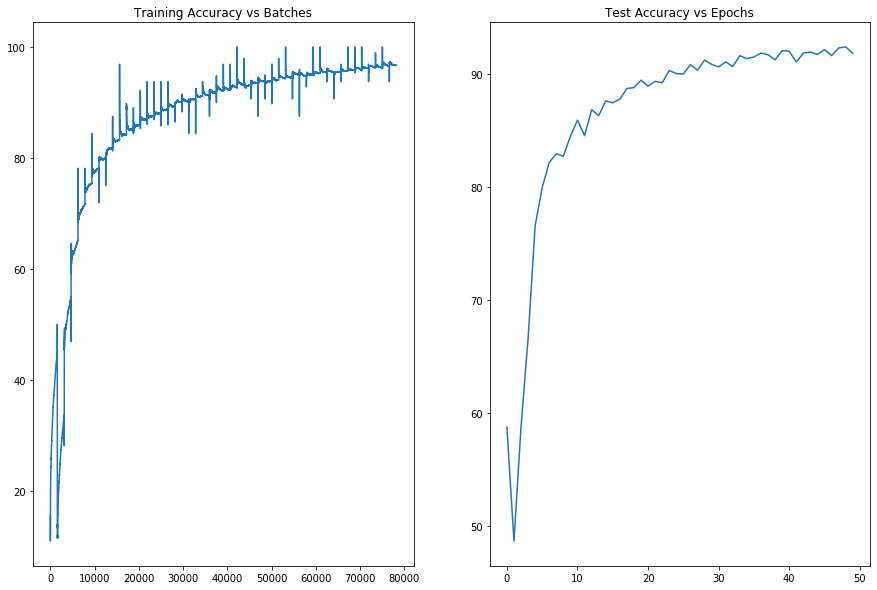

In [54]:
fig, axs = plt.subplots(1,2,figsize=(15,10))
axs[0].plot(train_acc)
axs[0].set_title("Training Accuracy vs Batches")

axs[1].plot(test_acc)
axs[1].set_title("Test Accuracy vs Epochs")

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:2427: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


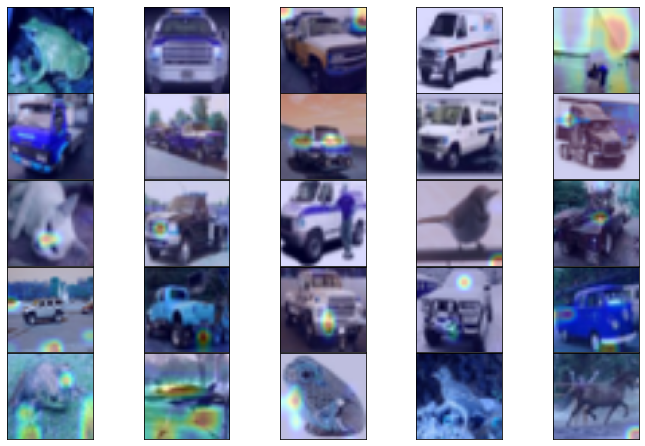

In [55]:
grad_cam = GradCam(model,            
                   target_layer_names=["layer3.1.conv2"],
                   use_cuda=use_cuda,
                   weights_path='/workspace/home/harv/Desktop/Session10/saves_2/checkpoint_check/49.pth')

len_mis_images = len(misclassified_list)
mis_imagelist = [misclassified_list[i][0].cpu() for i in range(len_mis_images)]  

mis_images = torch.stack(mis_imagelist)

returned_outputs_after_training = grad_cam(mis_images,
                                            dataset_mean=[0.5, 0.5, 0.5],
                                            dataset_std=[0.5, 0.5, 0.5],
                                            index=None,
                                            columns=5,
                                            rows=5)

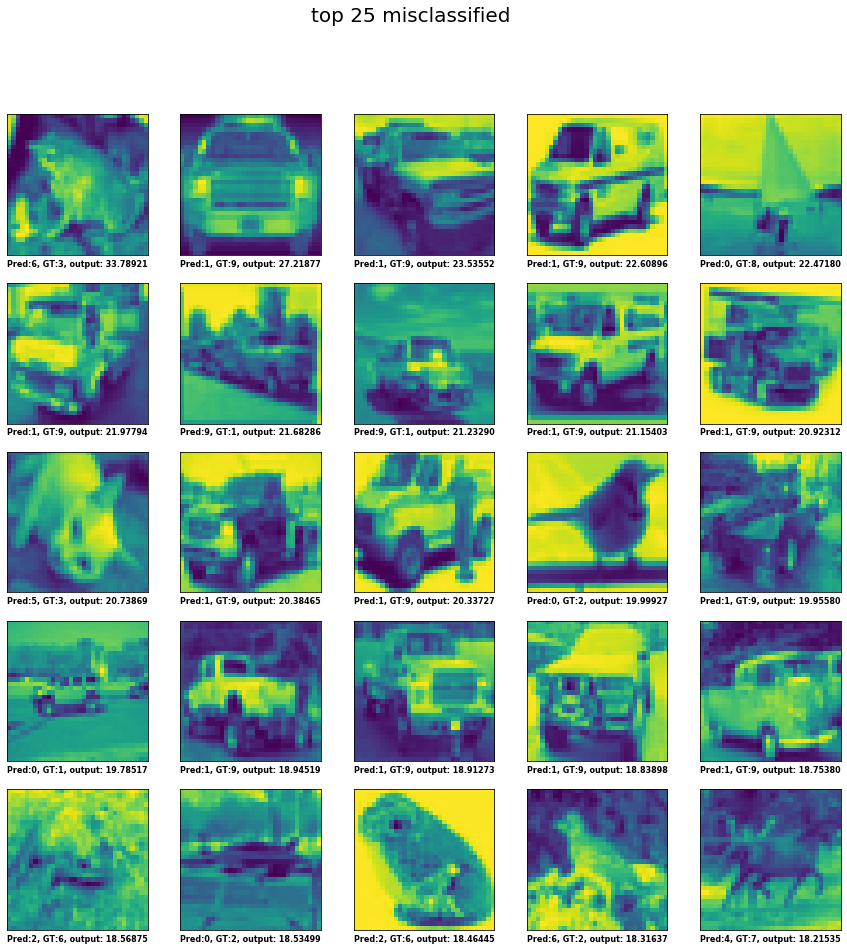

In [63]:
columns = 5
rows = 5 
fig=plt.figure(figsize=(15, 15))
for i in range(1, columns*rows +1):
    img = misclassified_list[i-1][0].cpu().numpy()[0]
    fig.add_subplot(rows, columns, i)
    fig.suptitle("top 25 misclassified", fontsize=20, horizontalalignment='center')
    xlabel = "Pred:{}, GT:{}, output: {:.5f}".format(misclassified_list[i-1][1], misclassified_list[i-1][3], misclassified_list[i-1][2])
    plt.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    plt.xlabel(xlabel, fontsize=8, color = 'black', fontweight='bold', horizontalalignment='center')
    plt.imshow(img)

plt.show()